### Correlation between variables

In [7]:
import pandas as pd

clean_df = pd.read_csv("Car_Crash_Cleaned_AADT.csv")
clean_df.columns

Index(['Collision Report Number', 'Collision Date', 'County', 'City',
       'Jurisdiction', 'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number',
       'Associated State Road Number', 'Block Number', 'Mile Post',
       'School Zone', 'Intersection Related', 'Weather Condition',
       'Lighting Condition', 'Injury Severity', 'Object Struck',
       'Damage Threshold Met', 'Hit and Run', 'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT'],
      dtype='object')

In [8]:
selected_columns = clean_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()
print(correlation_matrix)

                              Primary Road Number  Secondary Road Number  \
Primary Road Number                      1.000000              -0.123610   
Secondary Road Number                   -0.123610               1.000000   
Associated State Road Number             1.000000              -0.086525   
Mile Post                               -0.468186               0.198841   
School Zone                             -0.000197              -0.012598   
Intersection Related                     0.098841              -0.063330   
Damage Threshold Met                     0.013522              -0.000066   
Hit and Run                             -0.019999               0.025380   
Motor Vehicles Involved                  0.013080               0.061625   
Passengers Involved                     -0.016299               0.007411   
Commercial Carrier Involved             -0.043263               0.013175   
School Bus Involved                     -0.000050              -0.006759   
Pedestrians 

# QUESTIONS

QUESTION:  
What are the key predictors contributing to road collisions in Washington state at various scales (County, City level, type of road such as state or city.)?  
Now all state. So more specific to answer which is County Level (39), City Level (267)

IDEAS:


In [10]:
# Random Forest
# Model would look like by using Injury Severity(5 level) or Damage Threshold Met 
# Unknown Injury Collision, No Injury Collision, Minor Injury Collision, Serious Injury Collision, Fatal Collision

# FUNCTION

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def randomForest_function(df1, graph_name):
    """
    Function that generate features importance from random forest model with 100 tree and 5-fold cross-validation
    """
    # Filter if needed
    car_crash_data = df1

    # Dropping specified columns
    columns_to_drop = [
        'Primary Road Number', 'Secondary Trafficway', 
        'Secondary Road Number', 'Block Number', 'Mile Post',
        'Object Struck', 'Associated State Road Number', 'Collision Date'
    ]
    car_crash_data_cleaned = car_crash_data.drop(columns=columns_to_drop)
    
    # Encoding categorical variables
    label_encoder = LabelEncoder()
    for column in ['Weather Condition', 'Lighting Condition', 'Jurisdiction',
                   'Agency', 'Primary Trafficway', 'City', 'County']:
        car_crash_data_cleaned[column] = label_encoder.fit_transform(car_crash_data_cleaned[column])

    # Features and target variable
    X = car_crash_data_cleaned.drop(columns=['Collision Report Number', 'Injury Severity'])
    y = car_crash_data_cleaned['Injury Severity']
    
    # Encode target variable
    y = label_encoder.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build a Random Forest Classifier with GridSearchCV
    rf_classifier = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'criterion': ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_rf_classifier = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_rf_classifier.predict(X_test)
    
    # Evaluation
    classification_rep = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    # Get feature importances
    feature_importances = best_rf_classifier.feature_importances_
    feature_names = X.columns
    
    # Create a DataFrame for the feature importances
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
    
    # Print evaluation metrics
    print("Classification Report:\n", classification_rep)
    print("Confusion Matrix:\n", confusion_mat)
    print("Top 10 Feature Importances:\n", importance_df)

    path_name = 'visualization/' + graph_name
    
    # Visualizing feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(graph_name)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(path_name, bbox_inches='tight')
    plt.show()

def weather_condition(df2):
    # Grouping data by Lighting Condition and calculating summary statistics
    weather_summary = df2.groupby('Weather Condition').agg({
        'Collision Report Number': 'count',
        'Motor Vehicles Involved': 'sum',
        'Passengers Involved': 'sum',
        'Commercial Carrier Involved': 'sum',
        'School Bus Involved': 'sum',
        'Pedestrians Involved': 'sum',
        'Pedalcyclists Involved': 'sum',
        'AADT': 'mean'
    }).reset_index()
    
    # Renaming columns for clarity
    weather_summary.rename(columns={
        'Collision Report Number': 'Total Collisions',
        'Motor Vehicles Involved': 'Total Vehicles Involved',
        'Passengers Involved': 'Total Passengers Involved',
        'Commercial Carrier Involved': 'Total Commercial Carriers Involved',
        'School Bus Involved': 'Total School Buses Involved',
        'Pedestrians Involved': 'Total Pedestrians Involved',
        'Pedalcyclists Involved': 'Total Pedalcyclists Involved',
        'AADT': 'Average AADT'
    }, inplace=True)
    
    # Bar plot for total collisions by lighting condition
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Weather Condition', y='Total Collisions', data=weather_summary, palette='viridis')
    plt.title('Total Collisions by Weather Condition')
    plt.xlabel('Weather Condition')
    plt.ylabel('Total Collisions')
    plt.xticks(rotation=45)
    plt.savefig("weather_condition", bbox_inches='tight')
    plt.show()

def lighting_condition(df3):
    # Grouping data by Lighting Condition and calculating summary statistics
    lighting_summary = df3.groupby('Lighting Condition').agg({
        'Collision Report Number': 'count',
        'Motor Vehicles Involved': 'sum',
        'Passengers Involved': 'sum',
        'Commercial Carrier Involved': 'sum',
        'School Bus Involved': 'sum',
        'Pedestrians Involved': 'sum',
        'Pedalcyclists Involved': 'sum',
        'AADT': 'mean'
    }).reset_index()
    
    # Renaming columns for clarity
    lighting_summary.rename(columns={
        'Collision Report Number': 'Total Collisions',
        'Motor Vehicles Involved': 'Total Vehicles Involved',
        'Passengers Involved': 'Total Passengers Involved',
        'Commercial Carrier Involved': 'Total Commercial Carriers Involved',
        'School Bus Involved': 'Total School Buses Involved',
        'Pedestrians Involved': 'Total Pedestrians Involved',
        'Pedalcyclists Involved': 'Total Pedalcyclists Involved',
        'AADT': 'Average AADT'
    }, inplace=True)
    
    # Bar plot for total collisions by lighting condition
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Lighting Condition', y='Total Collisions', data=lighting_summary, palette='viridis')
    plt.title('Total Collisions by Lighting Condition')
    plt.xlabel('Lighting Condition')
    plt.ylabel('Total Collisions')
    plt.xticks(rotation=45)
    plt.savefig("lighting_condition", bbox_inches='tight')
    plt.show()

def stratified_sample_RF(df4):

    # filter out state road > 100
    filtered_df = df4.groupby('Associated State Road Number').filter(lambda x: len(x) > 100)
    # sample 100 from each state road
    sampled_df = filtered_df.groupby('Associated State Road Number').apply(lambda x: x.sample(100)).reset_index(drop=True)

    # Change fatality
    sampled_df['Injury Severity'] = sampled_df['Injury Severity'].apply(
        lambda x: 1 if x in ['Fatal Collision', 'Serious Injury Collision'] else 0
    )
    # call rf function
    randomForest_function(sampled_df, "Top_10_Feature_Importances_Stratified_sample")


##### Raw df

In [18]:
raw_df = pd.read_csv("data/Car_Crash_Cleaned_AADT.csv")

In [9]:
raw_df.columns

Index(['Collision Report Number', 'Collision Date', 'County', 'City',
       'Jurisdiction', 'Agency', 'Primary Trafficway', 'Primary Road Number',
       'Secondary Trafficway', 'Secondary Road Number',
       'Associated State Road Number', 'Block Number', 'Mile Post',
       'School Zone', 'Intersection Related', 'Weather Condition',
       'Lighting Condition', 'Injury Severity', 'Object Struck',
       'Damage Threshold Met', 'Hit and Run', 'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT'],
      dtype='object')

### Random Forest to all variables

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=entropy, max_depth=40, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=50, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=l

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.20      0.32        75
           1       0.55      0.11      0.18      1884
           2       0.76      0.97      0.85      6350
           3       0.68      0.08      0.14       162
           4       0.76      0.52      0.62       214

    accuracy                           0.75      8685
   macro avg       0.72      0.38      0.42      8685
weighted avg       0.71      0.75      0.68      8685

Confusion Matrix:
 [[  15    6   54    0    0]
 [   2  203 1671    4    4]
 [   1  148 6167    2   32]
 [   0   12  137   13    0]
 [   0    2  100    0  112]]
Top 10 Feature Importances:
                     Feature  Importance
4        Primary Trafficway    0.199100
17                     AADT    0.193525
1                      City    0.143517
0                    County    0.093810
11  Motor Vehicles Involved    0.091216
8        Lighting Condition    0.072131
7         Weather 

/tmp/ipykernel_99/153972058.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


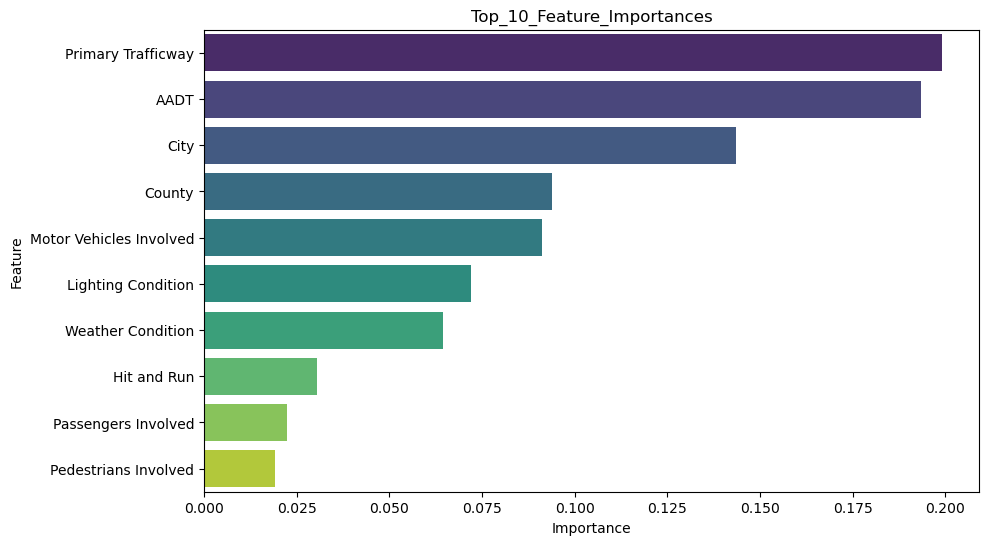

In [21]:
randomForest_function(raw_df, 'Top_10_Feature_Importances')

### Random Forest whether Fatal collision or not. Binary fatal

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8448
           1       0.56      0.13      0.21       237

    accuracy                           0.97      8685
   macro avg       0.77      0.56      0.60      8685
weighted avg       0.96      0.97      0.97      8685

Confusion Matrix:
 [[8424   24]
 [ 207   30]]
Top 10 Feature Importances:
                     Feature  Importance
4        Primary Trafficway    0.216887
17                     AADT    0.216124
1                      City    0.146025
0                    County    0.089542
15     Pedestrians Involved    0.060600
11  Motor Vehicles Involved    0.054954
8        Lighting Condition    0.053909
7         Weather Condition    0.051040
6      Intersection Related    0.022237
12      Passengers Involved    0.020653


/tmp/ipykernel_178/2944774010.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


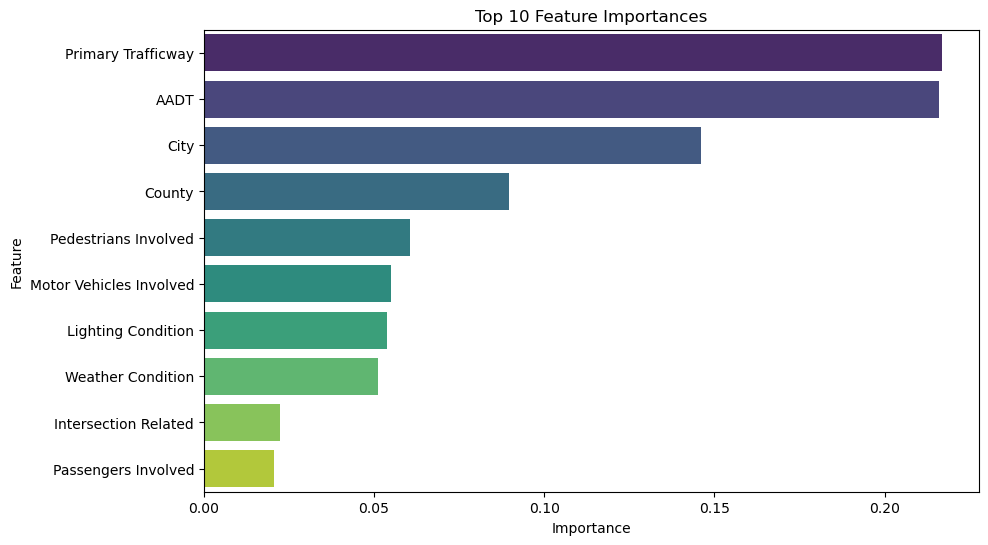

In [49]:
def fatal_rf(df2):

    temp_df = df2
    # Change fatality
    temp_df['Injury Severity'] = temp_df['Injury Severity'].apply(
        lambda x: 1 if x in ['Fatal Collision', 'Serious Injury Collision'] else 0
    )
    randomForest_function(temp_df, "Top 10 features of Fatal No Fatal")

fatal_rf(raw_df)

### Lighting Condition

/tmp/ipykernel_178/1666093263.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lighting Condition', y='Total Collisions', data=lighting_summary, palette='viridis')


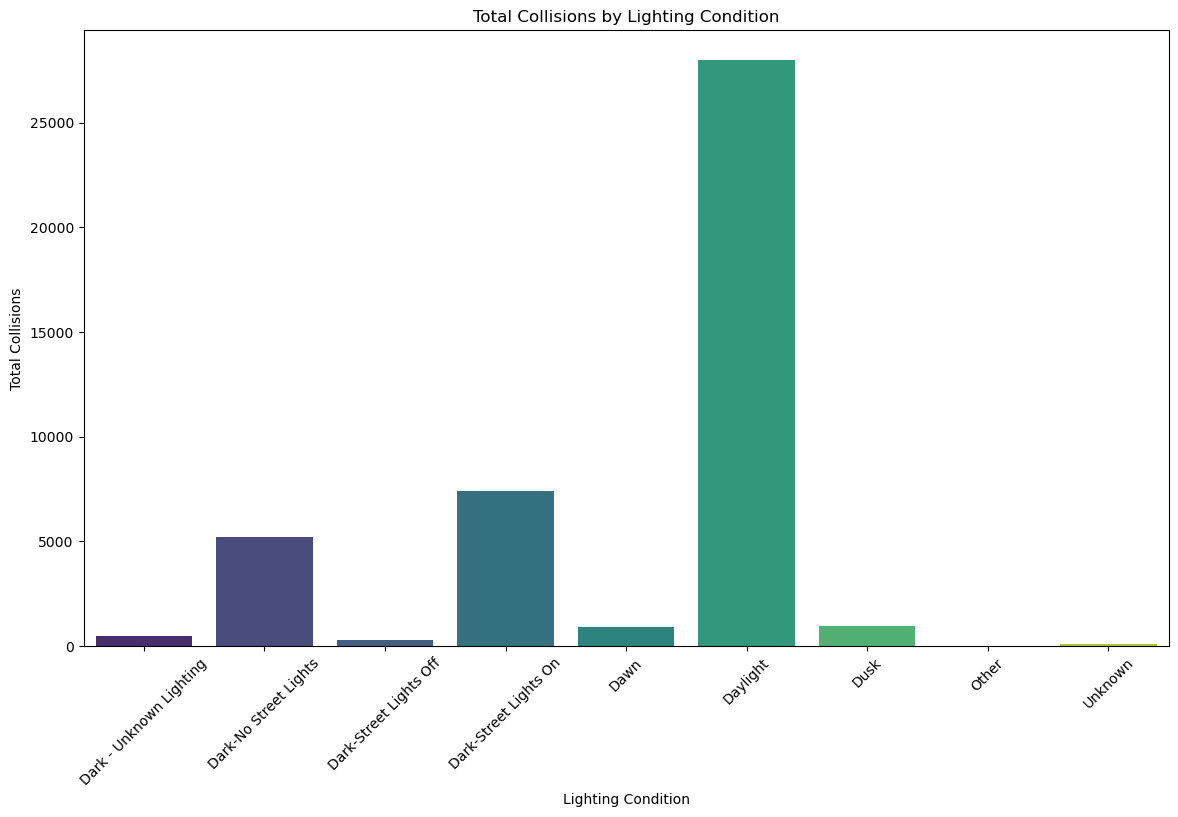

In [60]:
lighting_condition(raw_df)

### Weather Condition

/tmp/ipykernel_178/1666093263.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weather Condition', y='Total Collisions', data=weather_summary, palette='viridis')


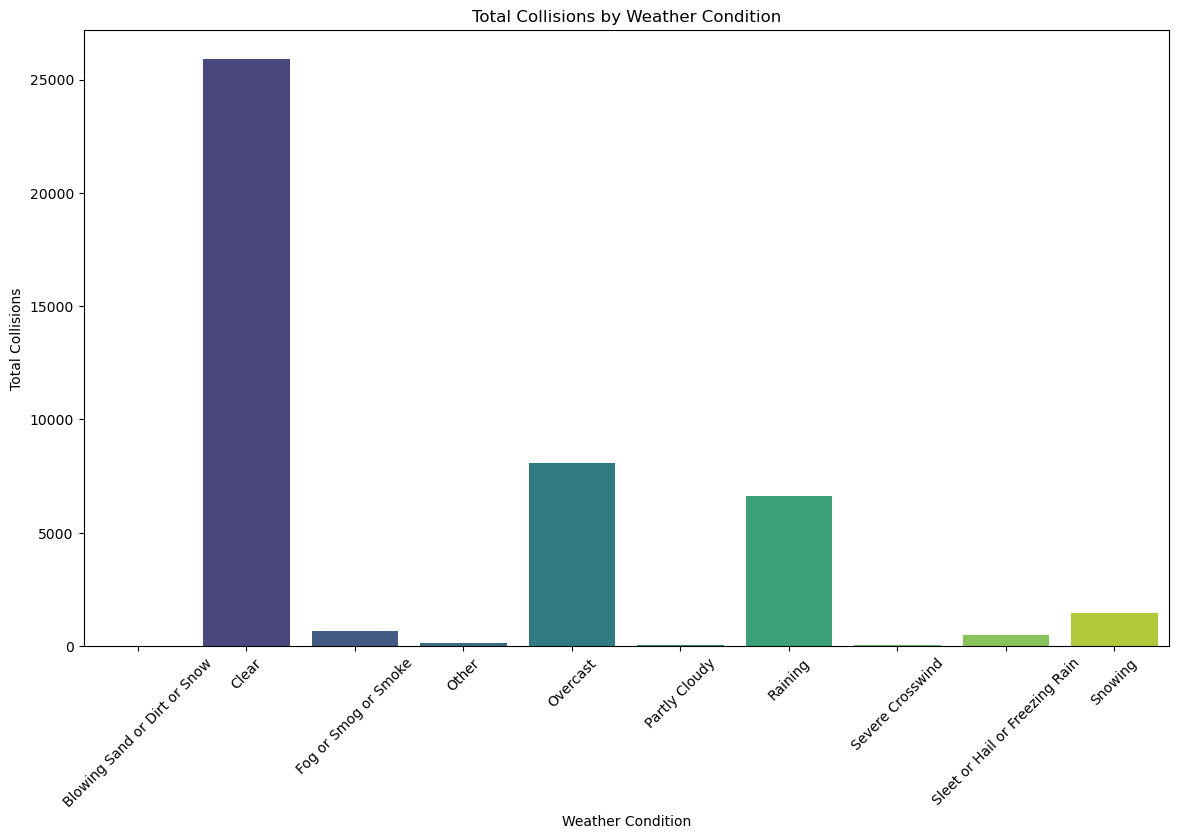

In [61]:
weather_condition(raw_df)

## Stratified sampling Random forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=auto, n_estim

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1099
           1       0.75      0.07      0.13        41

    accuracy                           0.97      1140
   macro avg       0.86      0.54      0.56      1140
weighted avg       0.96      0.97      0.95      1140

Confusion Matrix:
 [[1098    1]
 [  38    3]]
Top 10 Feature Importances:
                     Feature  Importance
17                     AADT    0.165292
4        Primary Trafficway    0.157803
1                      City    0.131626
15     Pedestrians Involved    0.106364
0                    County    0.095848
8        Lighting Condition    0.067465
11  Motor Vehicles Involved    0.062648
7         Weather Condition    0.060572
10              Hit and Run    0.027028
12      Passengers Involved    0.024505


/tmp/ipykernel_99/153972058.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


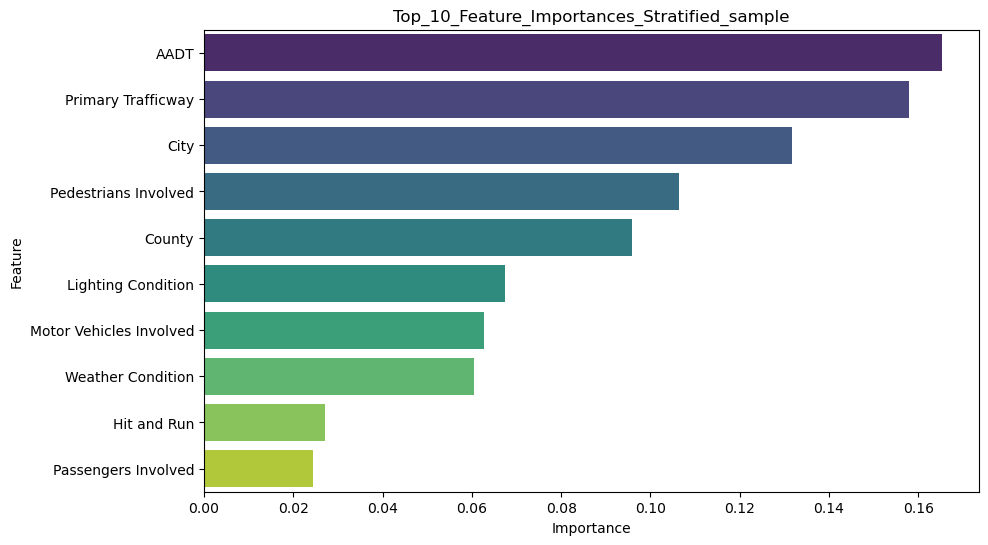

In [20]:
def stratified_sample_RF(df4):

    # filter out state road > 100
    filtered_df = df4.groupby('Associated State Road Number').filter(lambda x: len(x) > 100)
    # sample 100 from each state road
    sampled_df = filtered_df.groupby('Associated State Road Number').apply(lambda x: x.sample(100)).reset_index(drop=True)

    # Change fatality
    sampled_df['Injury Severity'] = sampled_df['Injury Severity'].apply(
        lambda x: 1 if x in ['Fatal Collision', 'Serious Injury Collision'] else 0
    )
    # call rf function
    randomForest_function(sampled_df, "Top_10_Feature_Importances_Stratified_sample")

stratified_sample_RF(raw_df)

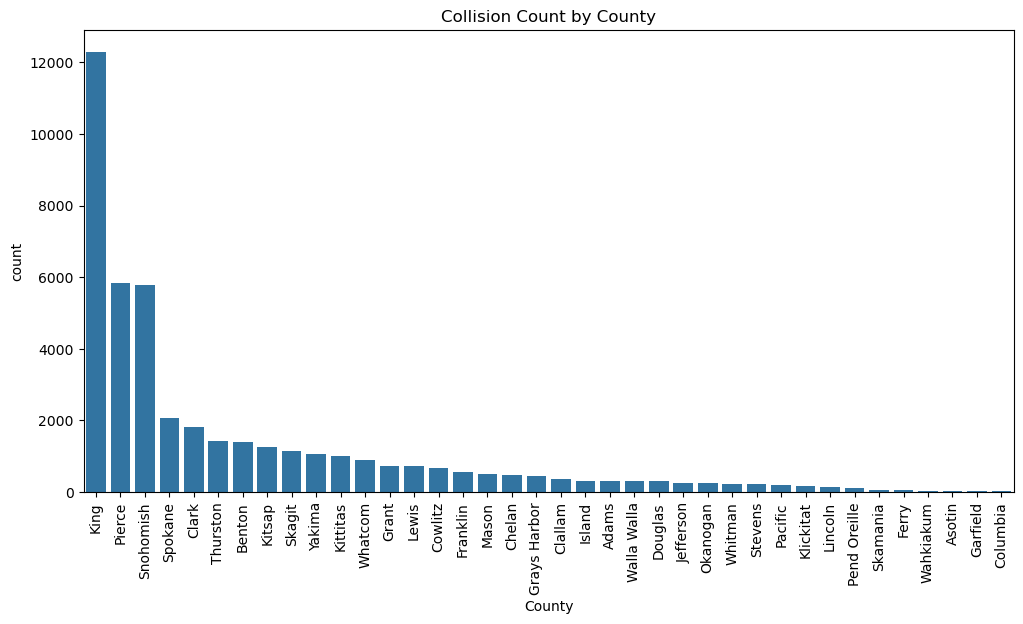

In [54]:
def county_by_collision_count(df2):

    temp_df = df2
    # Check for missing values
    missing_values = temp_df.isnull().sum()
    
    # Convert Collision Date to datetime
    temp_df['Collision Date'] = pd.to_datetime(temp_df['Collision Date'])
    
    # Feature Engineering: Extract year, month, day, hour
    temp_df['Year'] = temp_df['Collision Date'].dt.year
    temp_df['Month'] = temp_df['Collision Date'].dt.month
    temp_df['Hour'] = temp_df['Collision Date'].dt.hour
    
    # Visualization: Example for County Level
    plt.figure(figsize=(12, 6))
    sns.countplot(data=temp_df, x='County', order=temp_df['County'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title('Collision Count by County')
    plt.show()

county_by_collision_count(raw_df)


In [ ]:
#car_crash_data[(car_crash_data["County"] == "King") & (car_crash_data["City"] == "Seattle")] 3835
# car_crash_data[car_crash_data["County"] == "King"] 12293

In [ ]:
# Random Forest
# Model would look like by using Injury Severity(5 level) or Damage Threshold Met 
# Unknown Injury Collision, No Injury Collision, Minor Injury Collision, Serious Injury Collision, Fatal Collision

In [1]:
# Multinomial logistc regression 